In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib
#import seaborn as sns
from matplotlib import pylab as plt 
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] =100
plt.rcParams['agg.path.chunksize'] = 10000
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
seed = 42
train_df, test_df = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=seed)
train_df, val_df =train_test_split(train_df, stratify=train_df['Class'], test_size=0.2, random_state=seed)

In [6]:
y_train =train_df['Class'].values
y_val =val_df['Class'].values
y_test =test_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns').values
x_val = val_df.drop(['Class'], axis='columns').values
x_test = test_df.drop(['Class'], axis='columns').values

In [7]:
from numpy import bincount
neg, pos = bincount(y_train)
total = neg + pos

In [8]:
def compute_metrics(y_true, y_pred):
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    tp = int(tp.result().numpy())
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    fp = int(fp.result().numpy())
    tn = tf.keras.metrics.TrueNegatives()
    tn.update_state(y_true, y_pred)
    tn = int(tn.result().numpy())
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(y_true, y_pred)
    fn = int(fn.result().numpy())
    return [tp, fn, fp, tn]

In [9]:
tp_df = pd.DataFrame()
fn_df = pd.DataFrame()
fp_df = pd.DataFrame()
tn_df = pd.DataFrame()

In [10]:
def print_metrics(metrics):
    print('Fraudulent Transactions Detected (True Positives): '+ str(metrics[0]))
    print('Fraudulent Transactions Missed (False Negatives): '+ str(metrics[1]))
    print('Legitimate Transactions Incorrectly Dtected (False Positives): '+ str(metrics[2]))
    print('Legitimate Transactions Detected (True Negatives): '+ str(metrics[3]))

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

Wall time: 30 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [12]:
import tensorflow as tf
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.7488937

In [13]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)


Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 56860


In [14]:
%%time
from xgboost import XGBClassifier
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train)

C:\Users\Leonard\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 28.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [15]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.7611093

In [16]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 80
Fraudulent Transactions Missed (False Negatives): 18
Legitimate Transactions Incorrectly Dtected (False Positives): 6
Legitimate Transactions Detected (True Negatives): 56858


In [17]:
from tensorflow.keras.layers import Dense, Input, ELU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def create_model():
    tf.keras.backend.clear_session()
    input1 = Input(shape=(x_train.shape[1],), name='input1')
    x=Dense(96)(input1)
    x=BatchNormalization()(x)
    x=ELU()(x)
    x=Dropout(0.33)(x)
    x=Dense(96)(x)
    x=BatchNormalization()(x)
    x=ELU()(x)
    x=Dropout(0.33)(x)
    x=Dense(96)(x)
    x=BatchNormalization()(x)
    x=ELU()(x)
    x=Dropout(0.33)(x)
    out = Dense(1, activation='sigmoid', name='out')(x)
    
    
    _model = Model(inputs=[input1], outputs=[out])
    _model.summary()
    
    _model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'),
                                                                         tf.keras.metrics.AUC(curve='PR', name='auprc')])
    return _model

In [18]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [19]:
BATCH_SIZE=256

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True,
                    monitor='val_auprc', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

history=model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                 validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
713/713 - 3s - loss: 0.0593 - auroc: 0.8089 - auprc: 0.2348 - val_loss: 0.0057 - val_auroc: 0.9172 - val_auprc: 0.7104 - 3s/epoch - 5ms/step
Epoch 2/200
713/713 - 2s - loss: 0.0069 - auroc: 0.9051 - auprc: 0.6289 - val_loss: 0.0046 - val_auroc: 0.8858 - val_auprc: 0.6544 - 2s/epoch - 3ms/step
Epoch 3/200
713/713 - 2s - loss: 0.0051 - auroc: 0.9105 - auprc: 0.6831 - val_loss: 0.0045 - val_auroc: 0.9112 - val_auprc: 0.7044 - 2s/epoch - 3ms/step
Epoch 4/200
713/713 - 2s - loss: 0.0043 - auroc: 0.9248 - auprc: 0.7134 - val_loss: 0.0049 - val_auroc: 0.9112 - val_auprc: 0.7102 - 2s/epoch - 3ms/step
Epoch 5/200
713/713 - 2s - loss: 0.0043 - auroc: 0.9284 - auprc: 0.7098 - val_loss: 0.0040 - val_auroc: 0.9236 - val_auprc: 0.7146 - 2s/epoch - 3ms/step
Epoch 6/200
713/713 - 2s - loss: 0.0040 - auroc: 0.9285 - auprc: 0.7322 - val_loss: 0.0040 - val_auroc: 0.9237 - val_auprc: 0.7231 - 2s/epoch - 3ms/step
Epoch 7/200
713/713 - 2s - loss: 0.0036 - auroc: 0.9369 - auprc: 0.7660 - val_loss

In [21]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0027 - auroc: 0.9436 - auprc: 0.8430


[0.002703287871554494, 0.9436401724815369, 0.8429633975028992]

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

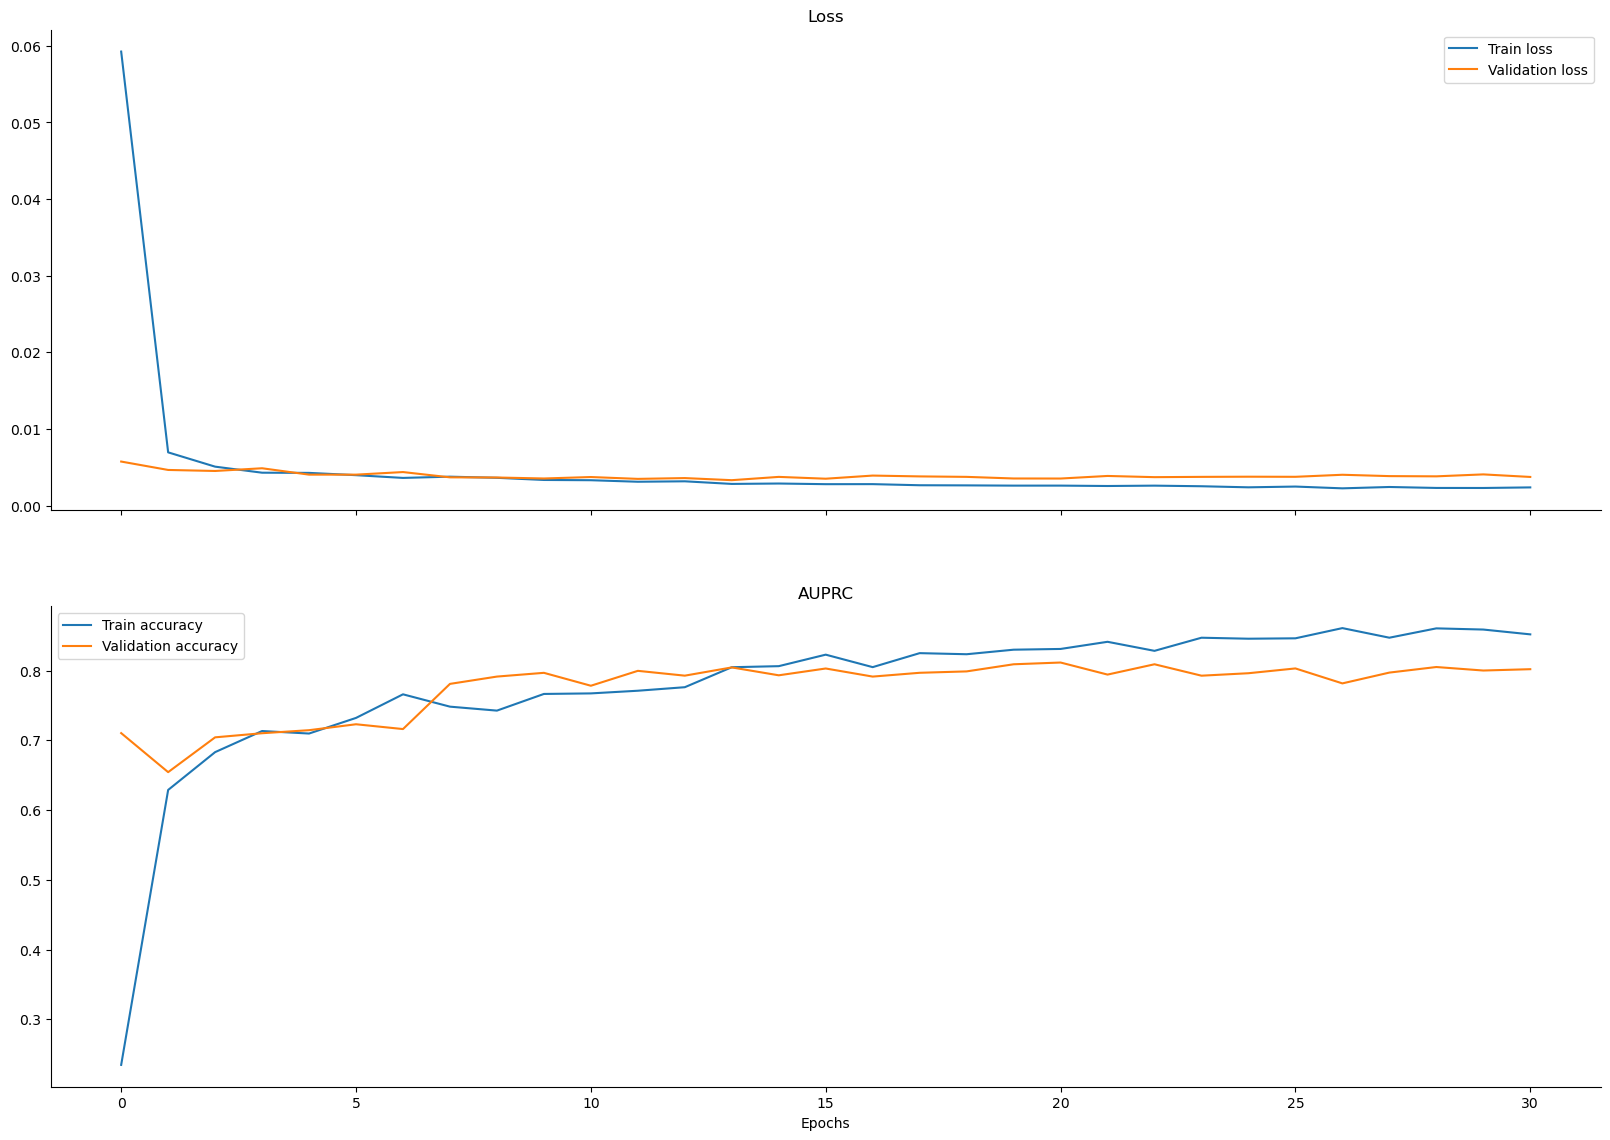

In [23]:
history = history.history
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col', figsize=(20,14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')
ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')
plt.xlabel('Epochs')
sns.despine()
plt.show()

In [24]:
y_pred = model.predict(x_test)
auprc =tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC


0.8429634

In [25]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 14
Legitimate Transactions Detected (True Negatives): 56850


In [26]:
print('Random Forest ***************************')
print_metrics(RF_metrics)
print('XGBoost ***********************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ********************')
print_metrics(TF_Model_metrics)

Random Forest ***************************
Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 56860
XGBoost ***********************************
Fraudulent Transactions Detected (True Positives): 80
Fraudulent Transactions Missed (False Negatives): 18
Legitimate Transactions Incorrectly Dtected (False Positives): 6
Legitimate Transactions Detected (True Negatives): 56858
TensorFlow DNN Model ********************
Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 14
Legitimate Transactions Detected (True Negatives): 56850


In [99]:
models = ['RandomForest', 'XGBoost', 'TensorFlow DNN']
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['baseline'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['baseline'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['baseline'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['baseline'] = results


In [100]:
auprc_df = pd.DataFrame()
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Model']  = models
auprc_df['baseline'] = results

In [101]:
#Using the loss function to focus more on the minority class, using class weights to achieve it during model fitting
classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [102]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.72788954

In [103]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 74
Fraudulent Transactions Missed (False Negatives): 24
Legitimate Transactions Incorrectly Dtected (False Positives): 3
Legitimate Transactions Detected (True Negatives): 56861


In [104]:
from math import sqrt
scale_pos_weight = sqrt(neg/pos)
xgbc = XGBClassifier(objective='binary:logistic', seed=seed,
                    scale_pos_weight=scale_pos_weight)
xgbc.fit(x_train, y_train)

C:\Users\Leonard\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24.08827303812342,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [105]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.7639222

In [106]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 82
Fraudulent Transactions Missed (False Negatives): 16
Legitimate Transactions Incorrectly Dtected (False Positives): 8
Legitimate Transactions Detected (True Negatives): 56856


In [107]:
#scaling by total/2 helps to keep the loss to a similar magnitude
#The sum of the weights of all examples stays the same

weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

model = create_model()

Weight for class 0: 1.60
Weight for class 1: 929.98
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
         

In [108]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                    monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')

history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], validation_data=(x_val, y_val),
                   class_weight=class_weight, batch_size=BATCH_SIZE)

Epoch 1/200
713/713 - 4s - loss: 0.8905 - auroc: 0.9554 - auprc: 0.2998 - val_loss: 0.1778 - val_auroc: 0.9525 - val_auprc: 0.5278 - 4s/epoch - 6ms/step
Epoch 2/200
713/713 - 2s - loss: 0.6576 - auroc: 0.9706 - auprc: 0.2622 - val_loss: 0.1459 - val_auroc: 0.9575 - val_auprc: 0.4222 - 2s/epoch - 3ms/step
Epoch 3/200
713/713 - 2s - loss: 0.5307 - auroc: 0.9801 - auprc: 0.4091 - val_loss: 0.1217 - val_auroc: 0.9635 - val_auprc: 0.6695 - 2s/epoch - 3ms/step
Epoch 4/200
713/713 - 2s - loss: 0.4911 - auroc: 0.9824 - auprc: 0.5259 - val_loss: 0.1083 - val_auroc: 0.9636 - val_auprc: 0.6658 - 2s/epoch - 3ms/step
Epoch 5/200
713/713 - 2s - loss: 0.5108 - auroc: 0.9818 - auprc: 0.4541 - val_loss: 0.1159 - val_auroc: 0.9659 - val_auprc: 0.6491 - 2s/epoch - 3ms/step
Epoch 6/200
713/713 - 2s - loss: 0.4299 - auroc: 0.9887 - auprc: 0.5423 - val_loss: 0.1151 - val_auroc: 0.9664 - val_auprc: 0.6678 - 2s/epoch - 3ms/step
Epoch 7/200
713/713 - 2s - loss: 0.4407 - auroc: 0.9865 - auprc: 0.5854 - val_loss

In [109]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 2s 874us/step - loss: 0.0641 - auroc: 0.9781 - auprc: 0.7262


[0.06407677382230759, 0.9780893921852112, 0.726152241230011]

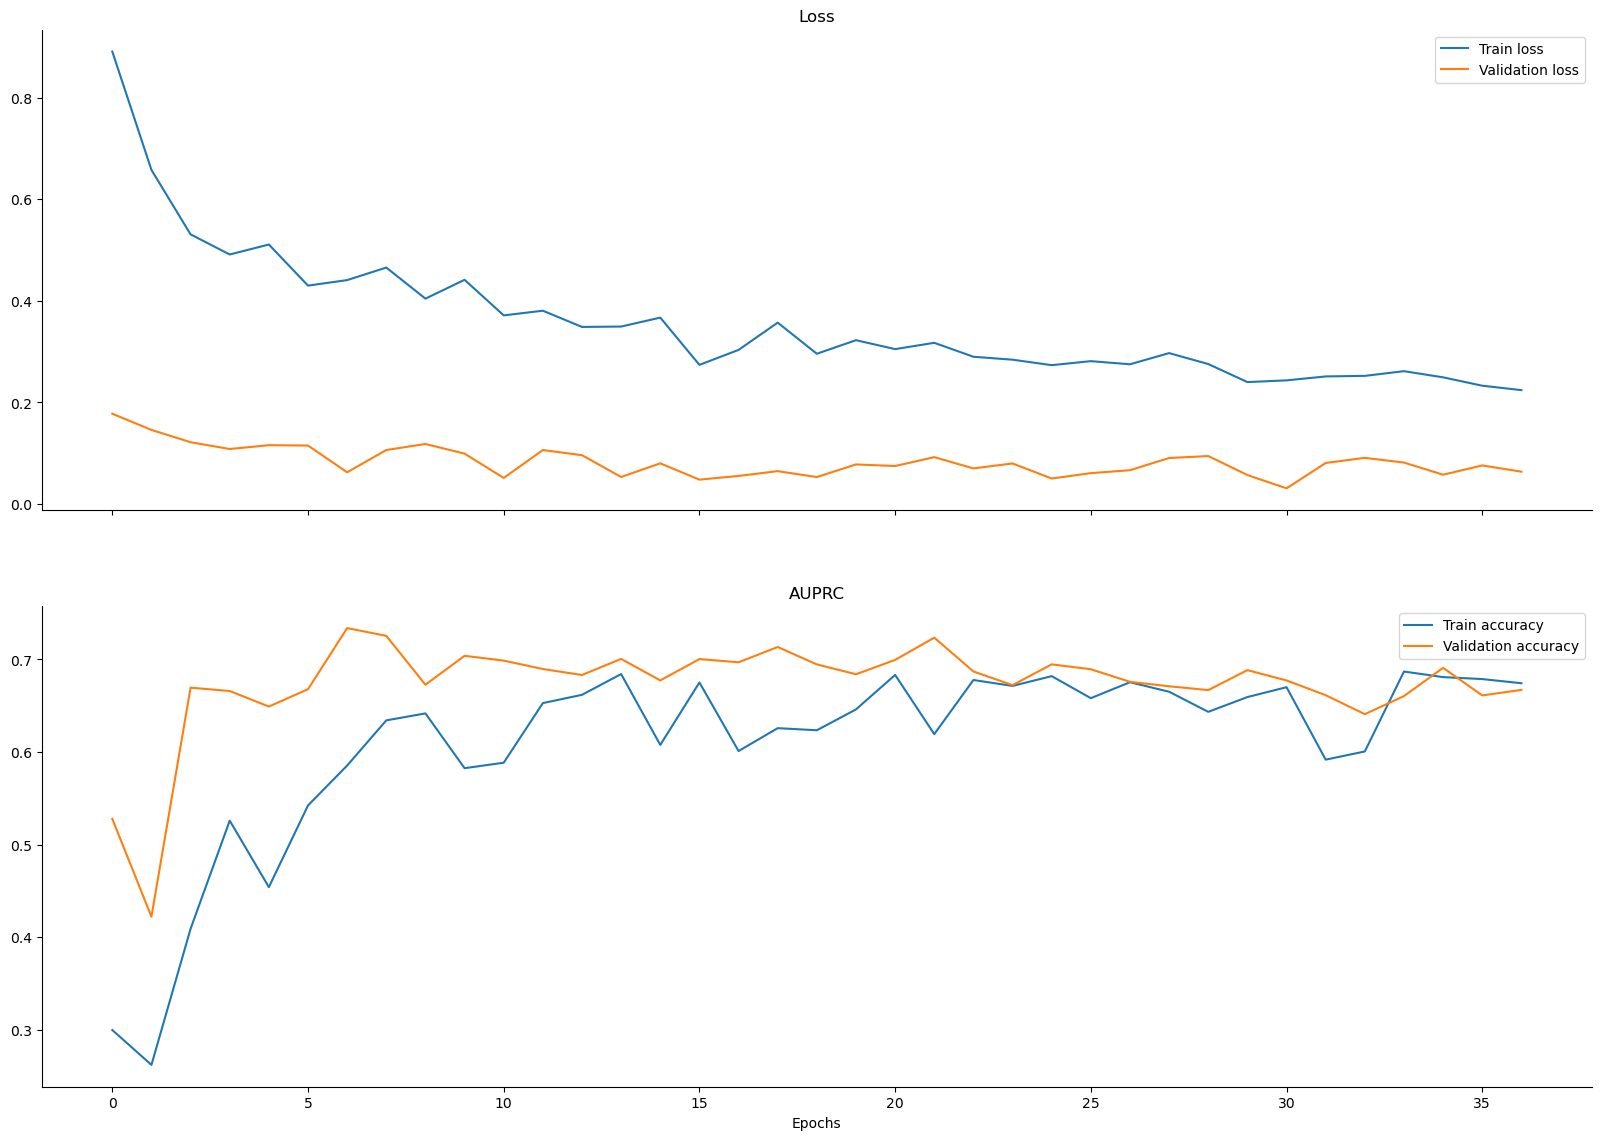

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
history = history.history
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')
ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [111]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.72615224

In [112]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Dtected (False Positives): 576
Legitimate Transactions Detected (True Negatives): 56288


In [113]:
print('RF_AUPRC: '+str(RF_AUPRC))
print('XGB_AUPRC: '+str(XGB_AUPRC))
print('TF_Model_AUPRC: '+str(TF_Model_AUPRC))

RF_AUPRC: 0.72788954
XGB_AUPRC: 0.7639222
TF_Model_AUPRC: 0.72615224


In [114]:
print('Random Forest ***********************')
print_metrics(RF_metrics)
print('XGBoost *****************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ****************')
print_metrics(TF_Model_metrics)

Random Forest ***********************
Fraudulent Transactions Detected (True Positives): 74
Fraudulent Transactions Missed (False Negatives): 24
Legitimate Transactions Incorrectly Dtected (False Positives): 3
Legitimate Transactions Detected (True Negatives): 56861
XGBoost *****************************
Fraudulent Transactions Detected (True Positives): 82
Fraudulent Transactions Missed (False Negatives): 16
Legitimate Transactions Incorrectly Dtected (False Positives): 8
Legitimate Transactions Detected (True Negatives): 56856
TensorFlow DNN Model ****************
Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Dtected (False Positives): 576
Legitimate Transactions Detected (True Negatives): 56288


In [115]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['class weighted'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['class weighted'] = results
fp_df['Model'] = models

results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['class weighted'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['class weighted'] = results

In [116]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['class weighted'] = results

In [118]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values

from numpy import bincount
neg, pos  = bincount(y_train)
print('Original balance: '+str(neg)+' non-fraud, '+str(pos)+' fraud')
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)
x_train, y_train = rus.fit_resample(x_train, y_train)
neg, pos = bincount(y_train)
print('New balance: '+str(neg)+' non-fraud, '+str(pos)+' fraud')

Original balance: 181961 non-fraud, 315 fraud
New balance: 315 non-fraud, 315 fraud


In [119]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [120]:
columns = train_df.columns.to_list()
columns.remove('Class')
print("The features' importance are: ")
for feature, value in zip(columns, classifier.feature_importances_):
    print(feature, value)

The features' importance are: 
V1 0.006289420354253885
V2 0.025671257777724676
V3 0.09957147082033363
V4 0.10974626347606665
V5 0.008192066624567063
V6 0.01112773484243107
V7 0.030010582420155592
V8 0.014271690744668091
V9 0.011024553244077265
V10 0.10191878781702048
V11 0.07489695961110066
V12 0.06545235660194416
V13 0.008699097829559377
V14 0.20572660551695615
V15 0.006316476857665142
V16 0.03699210144889733
V17 0.08162647779081615
V18 0.0074004191636887805
V19 0.012096704744413943
V20 0.009775716969998191
V21 0.013304419912372528
V22 0.004985930504483785
V23 0.006148881350009684
V24 0.00561494248441125
V25 0.00647917924118991
V26 0.006248624463265549
V27 0.011210816809643413
V28 0.0044767196761985074
scaled_amount 0.009168524796308157
scaled_time 0.005555216105779001


In [121]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.044665586

In [122]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 90
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Dtected (False Positives): 1780
Legitimate Transactions Detected (True Negatives): 55084


In [123]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train, eval_metric='aucpr')

C:\Users\Leonard\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [124]:
y_pred =xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.036482964

In [125]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 89
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Dtected (False Positives): 2157
Legitimate Transactions Detected (True Negatives): 54707


In [126]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [127]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True,
                    monitor='val_auprc', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc],
                   validation_data=(x_val, y_val), batch_size=8)

Epoch 1/200
79/79 - 7s - loss: 0.4102 - auroc: 0.8939 - auprc: 0.9149 - val_loss: 0.1087 - val_auroc: 0.9595 - val_auprc: 0.6760 - 7s/epoch - 87ms/step
Epoch 2/200
79/79 - 5s - loss: 0.2852 - auroc: 0.9474 - auprc: 0.9564 - val_loss: 0.0833 - val_auroc: 0.9710 - val_auprc: 0.6700 - 5s/epoch - 63ms/step
Epoch 3/200
79/79 - 5s - loss: 0.3041 - auroc: 0.9409 - auprc: 0.9544 - val_loss: 0.0655 - val_auroc: 0.9696 - val_auprc: 0.6589 - 5s/epoch - 65ms/step
Epoch 4/200
79/79 - 6s - loss: 0.2614 - auroc: 0.9539 - auprc: 0.9585 - val_loss: 0.0533 - val_auroc: 0.9680 - val_auprc: 0.7165 - 6s/epoch - 80ms/step
Epoch 5/200
79/79 - 6s - loss: 0.2858 - auroc: 0.9447 - auprc: 0.9569 - val_loss: 0.0967 - val_auroc: 0.9688 - val_auprc: 0.6824 - 6s/epoch - 79ms/step
Epoch 6/200
79/79 - 6s - loss: 0.2904 - auroc: 0.9453 - auprc: 0.9543 - val_loss: 0.0418 - val_auroc: 0.9723 - val_auprc: 0.6922 - 6s/epoch - 79ms/step
Epoch 7/200
79/79 - 6s - loss: 0.2698 - auroc: 0.9522 - auprc: 0.9582 - val_loss: 0.0736

In [128]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 2s 861us/step - loss: 0.0543 - auroc: 0.9734 - auprc: 0.6657


[0.05432083085179329, 0.9734094738960266, 0.6656976938247681]

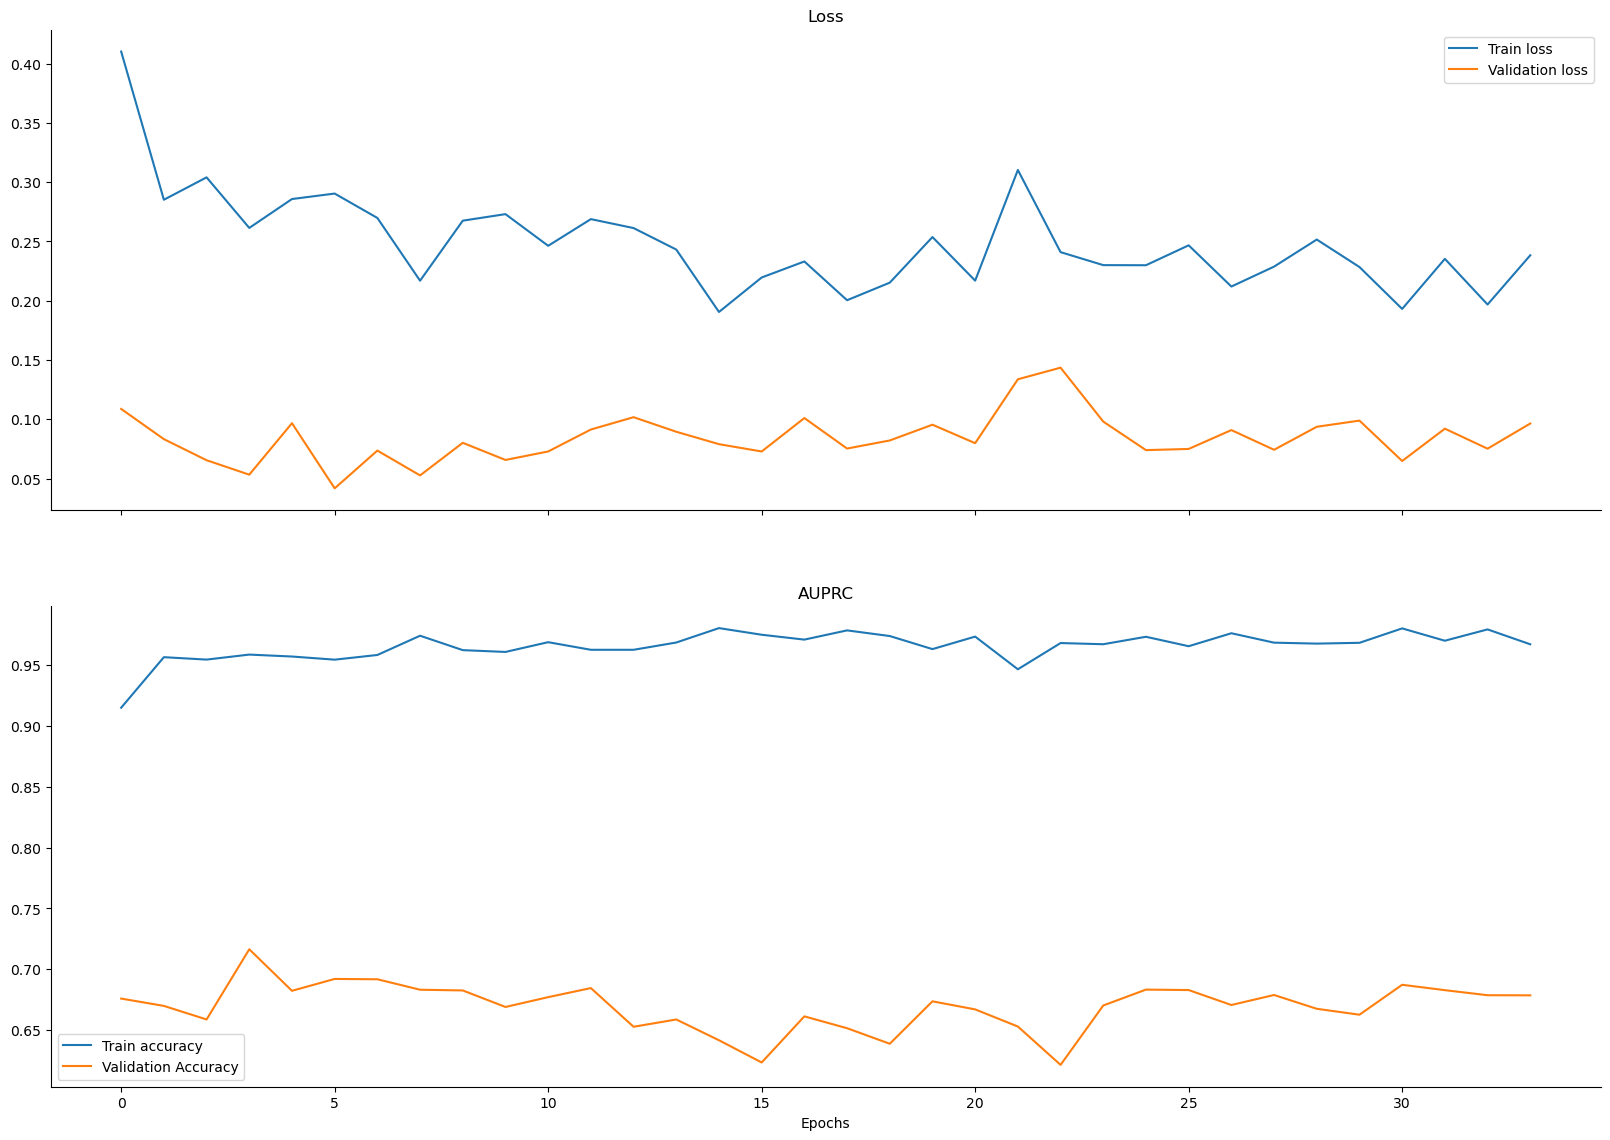

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))
ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label= 'Validation Accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')
plt.xlabel('Epochs')
sns.despine()
plt.show()



In [130]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.6656977

In [131]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 87
Fraudulent Transactions Missed (False Negatives): 11
Legitimate Transactions Incorrectly Dtected (False Positives): 320
Legitimate Transactions Detected (True Negatives): 56544


In [132]:
print('RF_AUPRC: '+str(RF_AUPRC))
print('XGB_AUPRC: '+str(XGB_AUPRC))
print('TF_Model_AUPRC: '+str(TF_Model_AUPRC))

RF_AUPRC: 0.044665586
XGB_AUPRC: 0.036482964
TF_Model_AUPRC: 0.6656977


In [133]:
print('Random Forest ******************************')
print_metrics(RF_metrics)
print('XGBoost ****************************')
print_metrics(XGB_metrics)
print('Tensorflow DNN Model ***************************')
print_metrics(TF_Model_metrics)

Random Forest ******************************
Fraudulent Transactions Detected (True Positives): 90
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Dtected (False Positives): 1780
Legitimate Transactions Detected (True Negatives): 55084
XGBoost ****************************
Fraudulent Transactions Detected (True Positives): 89
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Dtected (False Positives): 2157
Legitimate Transactions Detected (True Negatives): 54707
Tensorflow DNN Model ***************************
Fraudulent Transactions Detected (True Positives): 87
Fraudulent Transactions Missed (False Negatives): 11
Legitimate Transactions Incorrectly Dtected (False Positives): 320
Legitimate Transactions Detected (True Negatives): 56544


In [134]:
tp_df['Model'] = models
results =[RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['Undersampling (Random)'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['Undersampling(Random)'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['Undersampling(Random)'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['Undersampling(Random)'] = results

In [135]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Undersampling(Random)'] = results

In [136]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values
neg, pos = bincount(y_train)
print('Original balance: '+str(neg)+' non-fraud, '+str(pos)+ ' fraud')

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=seed)
x_train, y_train = ada.fit_resample(x_train, y_train)

neg, pos =bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' +str(pos)+ ' fraud')


Original balance: 181961 non-fraud, 315 fraud
New balance: 181961 non-fraud, 181956 fraud


In [137]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [138]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.6817282

In [139]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 12
Legitimate Transactions Detected (True Negatives): 56852


In [140]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)

xgbc.fit(x_train, y_train)

C:\Users\Leonard\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [141]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.6595204

In [142]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 85
Fraudulent Transactions Missed (False Negatives): 13
Legitimate Transactions Incorrectly Dtected (False Positives): 27
Legitimate Transactions Detected (True Negatives): 56837


In [143]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [144]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True,
                    monitor='val_auprc', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc],
                   validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
1422/1422 - 5s - loss: 0.1369 - auroc: 0.9879 - auprc: 0.9857 - val_loss: 0.0921 - val_auroc: 0.9407 - val_auprc: 0.3283 - 5s/epoch - 4ms/step
Epoch 2/200
1422/1422 - 4s - loss: 0.0616 - auroc: 0.9964 - auprc: 0.9948 - val_loss: 0.0564 - val_auroc: 0.9389 - val_auprc: 0.4194 - 4s/epoch - 3ms/step
Epoch 3/200
1422/1422 - 4s - loss: 0.0444 - auroc: 0.9977 - auprc: 0.9965 - val_loss: 0.0477 - val_auroc: 0.9360 - val_auprc: 0.3728 - 4s/epoch - 2ms/step
Epoch 4/200
1422/1422 - 4s - loss: 0.0352 - auroc: 0.9983 - auprc: 0.9973 - val_loss: 0.0319 - val_auroc: 0.9311 - val_auprc: 0.5226 - 4s/epoch - 3ms/step
Epoch 5/200
1422/1422 - 4s - loss: 0.0305 - auroc: 0.9986 - auprc: 0.9977 - val_loss: 0.0307 - val_auroc: 0.9201 - val_auprc: 0.4981 - 4s/epoch - 3ms/step
Epoch 6/200
1422/1422 - 4s - loss: 0.0267 - auroc: 0.9987 - auprc: 0.9979 - val_loss: 0.0283 - val_auroc: 0.9200 - val_auprc: 0.5235 - 4s/epoch - 3ms/step
Epoch 7/200
1422/1422 - 4s - loss: 0.0236 - auroc: 0.9990 - auprc: 0.9

Epoch 54/200
1422/1422 - 6s - loss: 0.0055 - auroc: 0.9998 - auprc: 0.9995 - val_loss: 0.0195 - val_auroc: 0.9045 - val_auprc: 0.6310 - 6s/epoch - 5ms/step
Epoch 55/200
1422/1422 - 4s - loss: 0.0054 - auroc: 0.9998 - auprc: 0.9996 - val_loss: 0.0187 - val_auroc: 0.9045 - val_auprc: 0.6218 - 4s/epoch - 3ms/step
Epoch 56/200
1422/1422 - 6s - loss: 0.0052 - auroc: 0.9998 - auprc: 0.9995 - val_loss: 0.0186 - val_auroc: 0.9046 - val_auprc: 0.6499 - 6s/epoch - 4ms/step
Epoch 57/200
1422/1422 - 5s - loss: 0.0052 - auroc: 0.9998 - auprc: 0.9996 - val_loss: 0.0207 - val_auroc: 0.9044 - val_auprc: 0.6272 - 5s/epoch - 3ms/step
Epoch 58/200
1422/1422 - 4s - loss: 0.0052 - auroc: 0.9998 - auprc: 0.9996 - val_loss: 0.0206 - val_auroc: 0.9045 - val_auprc: 0.6303 - 4s/epoch - 3ms/step
Epoch 59/200
1422/1422 - 5s - loss: 0.0050 - auroc: 0.9998 - auprc: 0.9996 - val_loss: 0.0192 - val_auroc: 0.9109 - val_auprc: 0.6485 - 5s/epoch - 3ms/step
Epoch 60/200
1422/1422 - 6s - loss: 0.0053 - auroc: 0.9998 - aup

Epoch 107/200
1422/1422 - 5s - loss: 0.0037 - auroc: 0.9998 - auprc: 0.9996 - val_loss: 0.0212 - val_auroc: 0.8983 - val_auprc: 0.6408 - 5s/epoch - 3ms/step
Epoch 00107: early stopping


In [145]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0124 - auroc: 0.9383 - auprc: 0.6727


[0.012357457540929317, 0.9382839798927307, 0.6727436184883118]

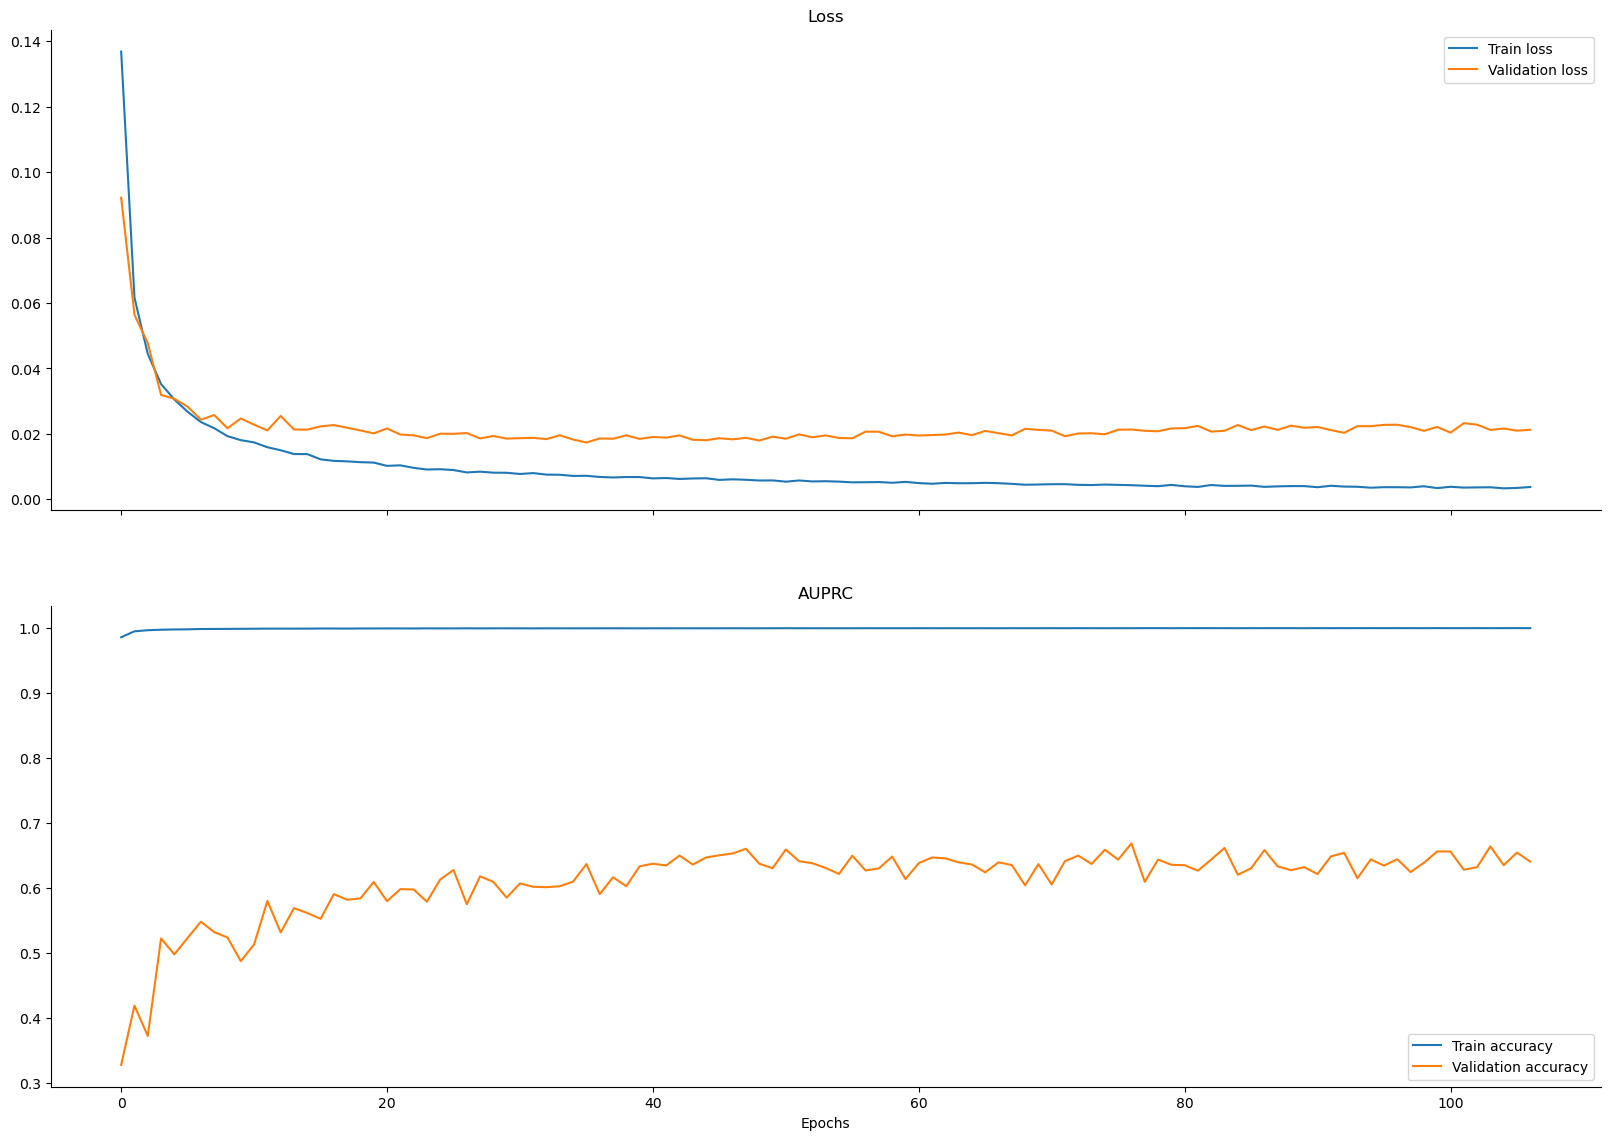

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
history = history.history
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))
ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [147]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC


0.6727436

In [148]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 82
Fraudulent Transactions Missed (False Negatives): 16
Legitimate Transactions Incorrectly Dtected (False Positives): 70
Legitimate Transactions Detected (True Negatives): 56794


In [149]:
print('RF_AUPRC: '+str(RF_AUPRC))
print('XGB_AUPRC: '+str(XGB_AUPRC))
print('TF_Model_AUPRC: '+str(TF_Model_AUPRC))

RF_AUPRC: 0.6817282
XGB_AUPRC: 0.6595204
TF_Model_AUPRC: 0.6727436


In [150]:
print('Random Forest *****************************')
print_metrics(RF_metrics)
print('XGBoost ******************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model *******************')
print_metrics(TF_Model_metrics)

Random Forest *****************************
Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Dtected (False Positives): 12
Legitimate Transactions Detected (True Negatives): 56852
XGBoost ******************************
Fraudulent Transactions Detected (True Positives): 85
Fraudulent Transactions Missed (False Negatives): 13
Legitimate Transactions Incorrectly Dtected (False Positives): 27
Legitimate Transactions Detected (True Negatives): 56837
TensorFlow DNN Model *******************
Fraudulent Transactions Detected (True Positives): 82
Fraudulent Transactions Missed (False Negatives): 16
Legitimate Transactions Incorrectly Dtected (False Positives): 70
Legitimate Transactions Detected (True Negatives): 56794


In [151]:
tp_df['Model'] =models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['ADASYN'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['ADASYN'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['ADASYN'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['ADASYN'] = results

In [152]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]

In [153]:
auprc_df['Oversampling ADASYN'] = results


In [154]:
neg, pos = bincount(y_test)
print(str(neg)+' non-fraud, '+str(pos)+' fraud')

56864 non-fraud, 98 fraud


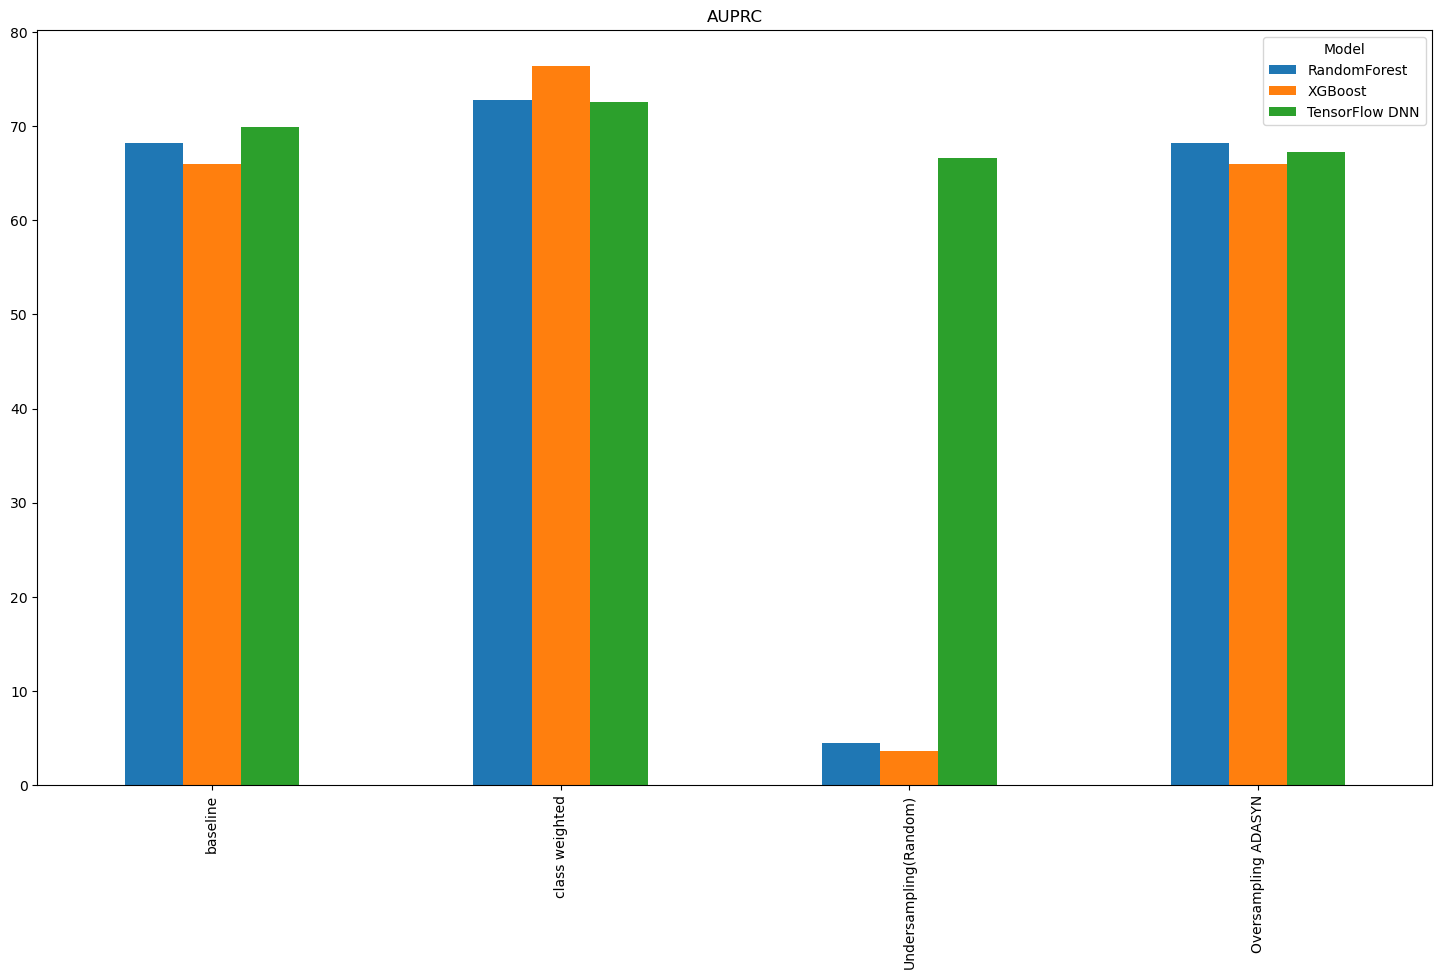

In [155]:
a = auprc_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a= a.T
a['RandomForest'] = a['RandomForest']*100
a['XGBoost'] = a['XGBoost']*100
a['TensorFlow DNN'] = a['TensorFlow DNN']*100
ax = a.plot.bar(rot=90, figsize=(18, 10), title='AUPRC')

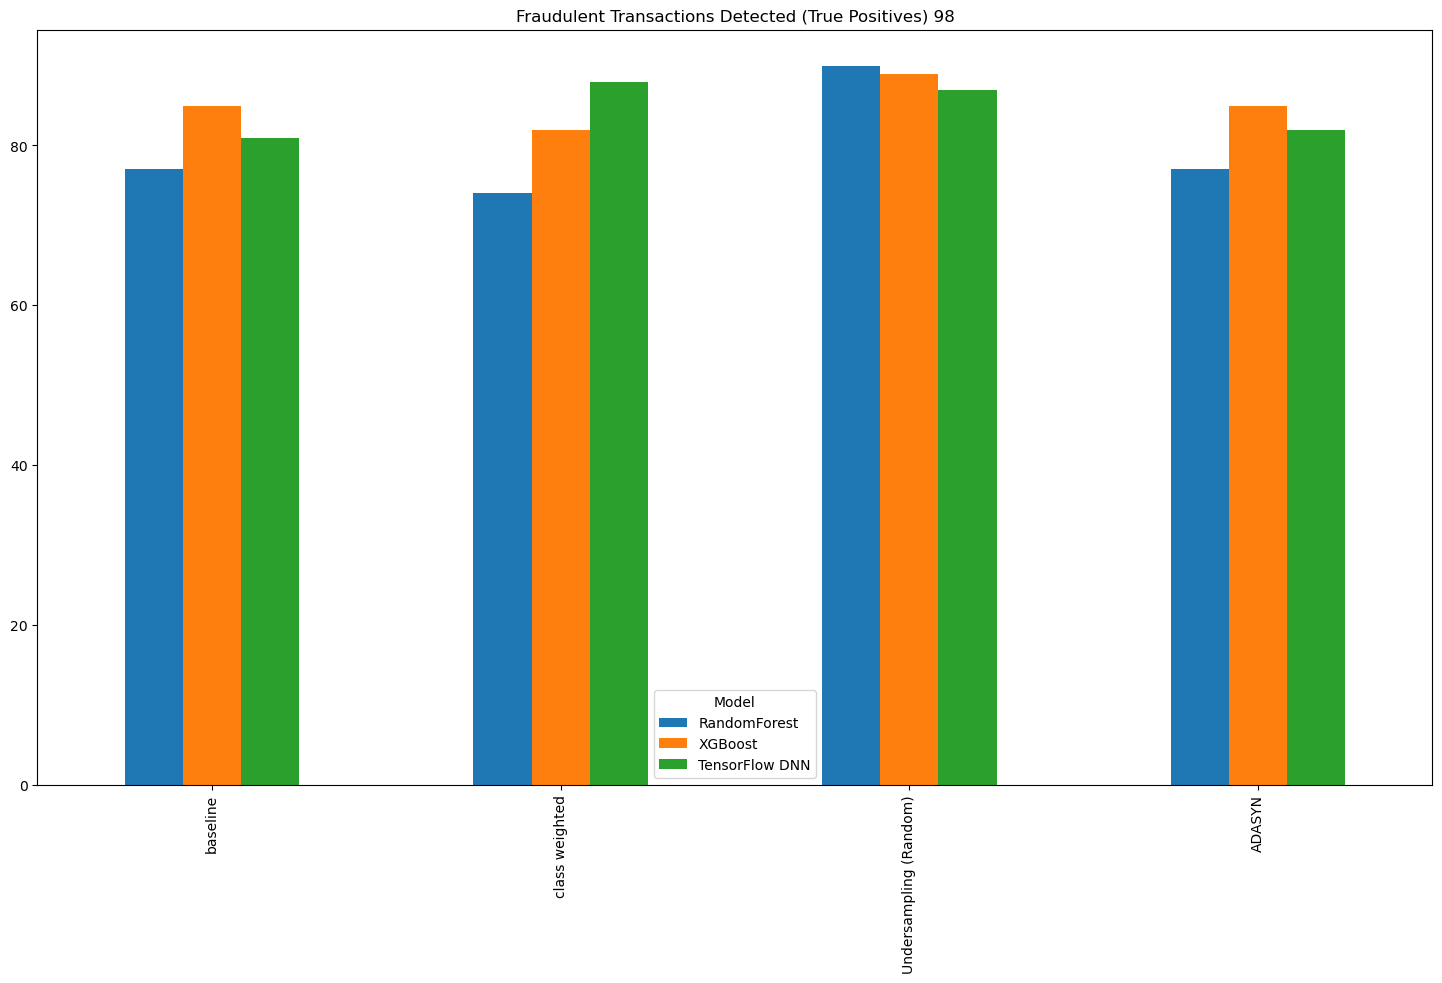

In [156]:
a= tp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a=a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Detected (True Positives) 98')

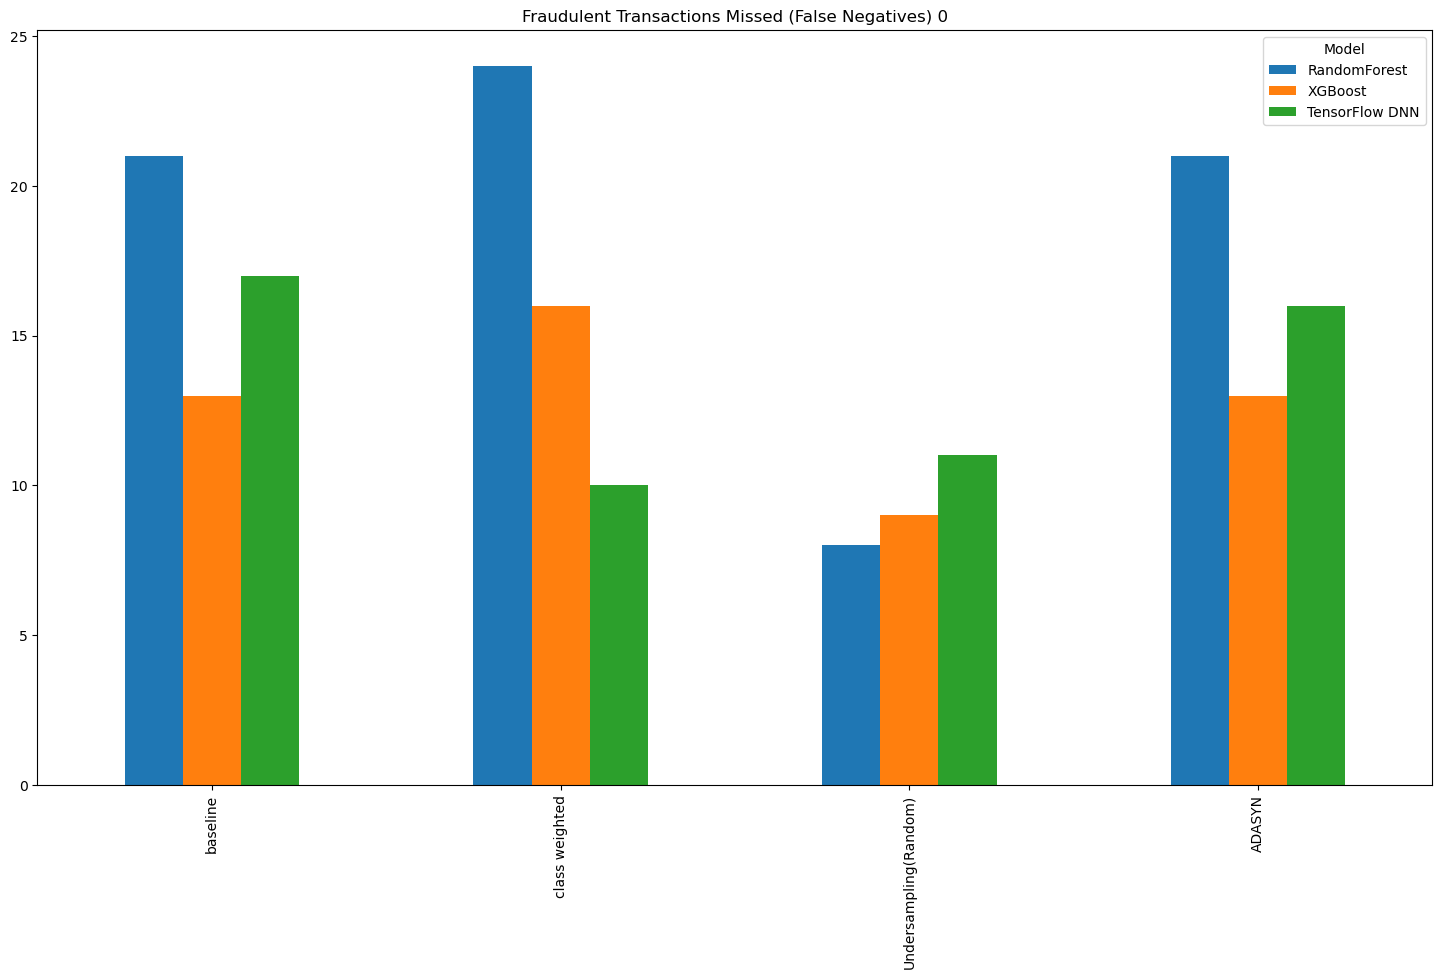

In [157]:
a = fn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a=a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Missed (False Negatives) 0')

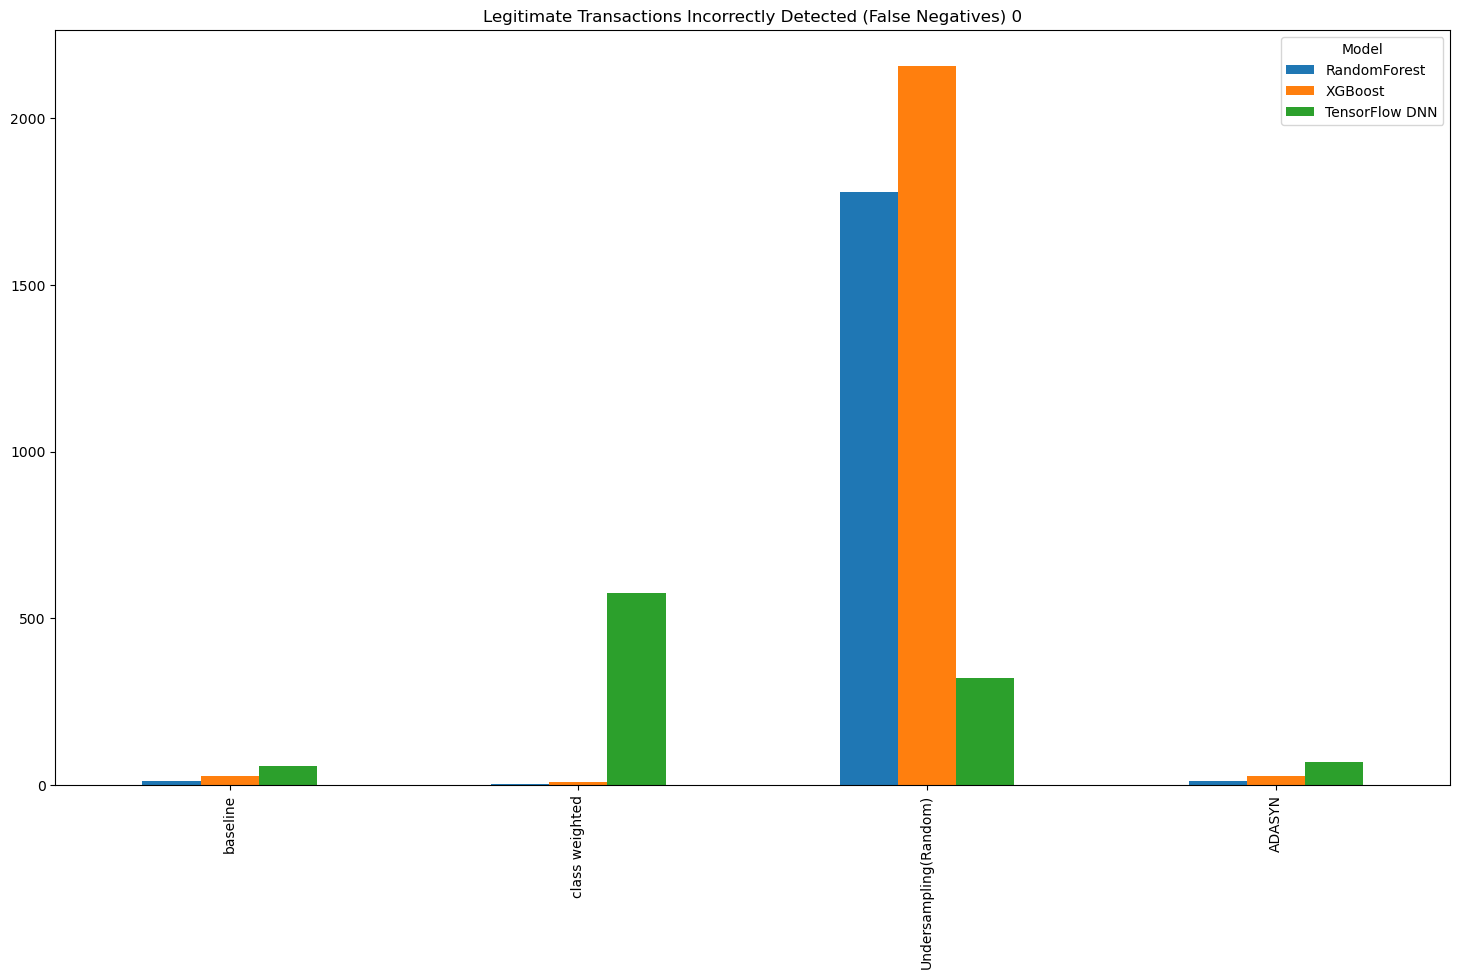

In [158]:
a= fp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a=a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Incorrectly Detected (False Negatives) 0')

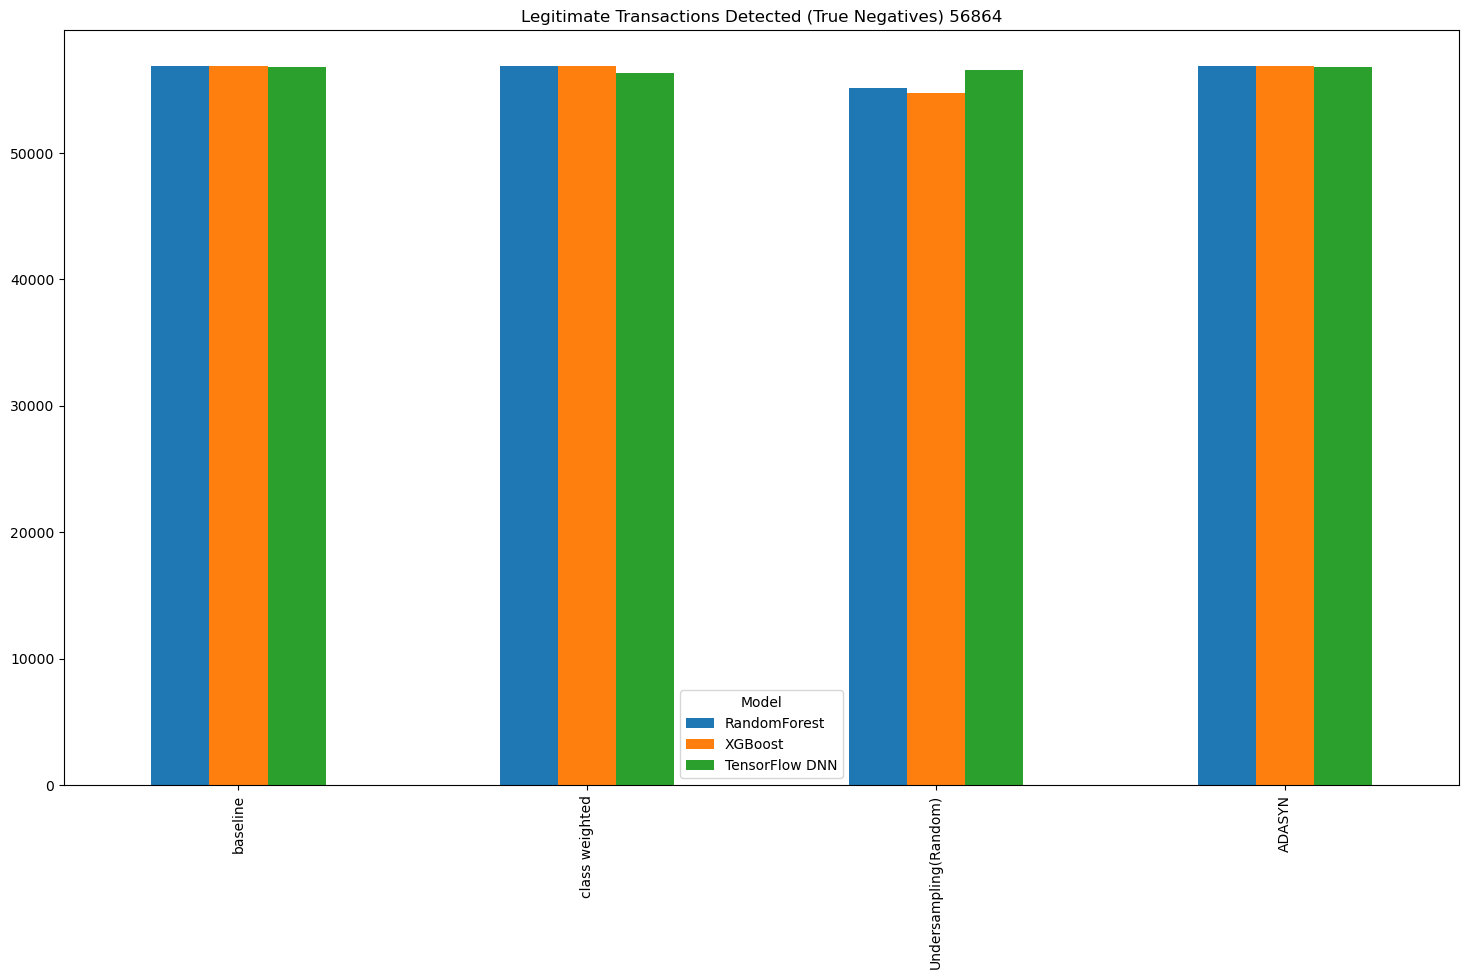

In [160]:
a= tn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Detected (True Negatives) 56864')